In [2]:
# ============================================================================
# IMPORT CÁC THƯ VIỆN CẦN THIẾT CHO XAI-RL FRAMEWORK
# ============================================================================

# 1. System & Path
import sys
import os
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')

# 2. Data Processing
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 3. Deep Learning - PyTorch
import torch
from torch import nn
import torch.nn.functional as F

# 4. Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style cho plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 5. XAI Libraries - CHỈ DÙNG SHAP
try:
    import shap
    print("✓ SHAP available")
except ImportError:
    print("⚠ SHAP not installed - will install when needed")

# 6. Project-specific Imports
from agents.d_sarsa.d_sarsa import Qsa
from environments.stock_trading_env.mdp import StockTradingMDP
from data.data_provider.library_extracted.vnstock.VNStockDataProvider import VNStockDataProvider
from data.data_processor.feature_engineer import engineer_stat as es

# 7. Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("="*80)
print("✓ Tất cả thư viện đã được import thành công!")
print("="*80)
print("\n🎯 XAI-RL Framework - 3 Phương pháp độc lập:")
print("  [1] RDX  - Reward Decomposition (weights từ domain knowledge)")
print("  [2] MSX  - Multi-Step Explanation (trajectory analysis)")
print("  [3] SHAP - Feature Attribution (Shapley values)")
print("\n📊 Deep RL Agent:")
print("  • Qsa:              Q-network (input=7, output=11)")
print("  • StockTradingMDP:  Environment cho stock trading")
print("  • VNStockData:      Data provider cho VN market")
print("\nReady to analyze SARSA agent! 🚀")
print("="*80)

✓ SHAP available


✓ Tất cả thư viện đã được import thành công!

🎯 XAI-RL Framework - 3 Phương pháp độc lập:
  [1] RDX  - Reward Decomposition (weights từ domain knowledge)
  [2] MSX  - Multi-Step Explanation (trajectory analysis)
  [3] SHAP - Feature Attribution (Shapley values)

📊 Deep RL Agent:
  • Qsa:              Q-network (input=7, output=11)
  • StockTradingMDP:  Environment cho stock trading
  • VNStockData:      Data provider cho VN market

Ready to analyze SARSA agent! 🚀


In [3]:
# 1.1. Load model SARSA
qsa = Qsa(input_size=7, num_classes=11)
model_path = 'd:\\NCKH\\SARSA_FinancialRL\\models\\sarsa_bad_acb.pth'

if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    qsa.load_state_dict(state_dict)
    qsa.eval()
    print(f"✓ Model loaded: {model_path}")
else:
    print(f"✗ Model not found: {model_path}")

# 1.2. Load dữ liệu ACB
provider = VNStockDataProvider()
print("\nĐang lấy dữ liệu ACB từ vnstock...")
df_raw = provider.get_ohlcv_data('ACB', '2019-12-14', '2022-12-31')
print(f"✓ Đã lấy {len(df_raw)} dòng dữ liệu")

# 1.3. Xử lý dữ liệu và thêm technical indicators
df_processed = df_raw.copy()
df_processed.rename(columns={'date': 'time'}, inplace=True)
df_processed['time'] = pd.to_datetime(df_processed['time']).dt.strftime('%d/%m/%Y')
df_processed = es.add_technical_indicators(df_processed, start_date= '01/01/2020')
print(f"✓ Đã thêm technical indicators: {df_processed.shape}")

# 1.4. Khởi tạo MDP và chạy simulation
mdp = StockTradingMDP(balance_init=1000, k=5, min_balance=-100)

def pi_deep(s, eps=0.0, greedy=True):
    with torch.no_grad():
        out_qsa = qsa(torch.Tensor(s).float()).squeeze()
        action = out_qsa.argmax().item() - 5
    return action

# State ban đầu
first_row = df_processed.iloc[0]
state_init = [
    float(first_row['close']),
    mdp.balance_init,
    0,
    float(first_row['MACD']),
    float(first_row['RSI']),
    float(first_row['CCI']),
    float(first_row['ADX'])
]

# Chạy simulation
print("\nĐang chạy simulation...")
states, rewards, actions = mdp.simulate(
    df_processed[1:].reset_index(drop=True), 
    state_init, 
    pi_deep, 
    greedy=True, 
    eps=0.0
)

print(f"✓ Simulation hoàn tất: {len(states)} states, {len(actions)} actions")
print(f"  Total reward: {sum(rewards):.2f}")
print(f"  Final portfolio: ${states[-1][1] + states[-1][0]*states[-1][2]:.2f}")

✓ Model loaded: d:\NCKH\SARSA_FinancialRL\models\sarsa_bad_acb.pth

Đang lấy dữ liệu ACB từ vnstock...
LẤY DỮ LIỆU OHLCV TỪ VNSTOCK
📋 Danh sách mã: ['ACB']
📅 Khoảng thời gian: 2019-12-14 đến 2022-12-31
⏱️  Phiên: 1D
📡 Nguồn: VCI
--------------------------------------------------------------------------------
📡 Đang lấy dữ liệu cho ACB...
✅ ACB: 796 dòng

KẾT QUẢ
✅ Tổng số dòng dữ liệu: 796
✅ Số mã thành công: 1

📋 Các cột dữ liệu:
   • date
   • open
   • high
   • low
   • close
   • volume
   • symbol

📊 Thống kê:
   • Số mã: 1
   • Khoảng thời gian: 2019-10-23 đến 2022-12-30

📄 Mẫu dữ liệu (10 dòng đầu):
         date  open  high   low  close   volume symbol
0  2019/10/23  6.78  6.84  6.78   6.78   983685    ACB
1  2019/10/24  6.81  6.81  6.75   6.81   921275    ACB
2  2019/10/25  6.81  6.81  6.75   6.81  1105479    ACB
3  2019/10/28  6.81  6.90  6.81   6.84  1090296    ACB
4  2019/10/29  6.87  6.90  6.81   6.84  1702377    ACB
5  2019/10/30  6.87  7.04  6.81   7.01  7431303    ACB


In [13]:
df_processed

,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
0,02/01/2020,6.58,6.64,6.55,6.64,1163109,-0.053056,51.322363,39.862543,28.414155
1,03/01/2020,6.64,6.70,6.61,6.64,1055528,-0.044602,51.322363,105.841924,26.620760
2,06/01/2020,6.64,6.64,6.49,6.49,1286035,-0.049437,40.880026,-69.800570,26.129931
3,07/01/2020,6.49,6.55,6.49,6.49,1050934,-0.052661,40.880026,-106.989247,25.674161
4,08/01/2020,6.49,6.49,6.35,6.38,2304937,-0.063362,34.849461,-219.047619,26.323144
...,...,...,...,...,...,...,...,...,...,...
741,26/12/2022,13.42,13.42,12.96,12.96,1779728,0.170446,47.439644,-87.209302,12.983335
742,27/12/2022,12.96,13.25,12.90,12.96,2041994,0.131652,47.439644,-124.679357,12.973873
743,28/12/2022,12.96,13.16,12.87,12.90,1827577,0.094971,46.387546,-149.728997,13.039226
744,29/12/2022,12.90,13.13,12.78,12.90,1810363,0.065150,46.387546,-149.024024,13.327816


## SHAP cho states agent vừa mô phỏng
Mục tiêu: giải thích đóng góp của từng feature (giá, vốn, vị thế, MACD, RSI, CCI, ADX) lên Q-value của hành động mà agent đã chọn tại mỗi timestep. Chúng ta sử dụng KernelExplainer cho dữ liệu tabular và hàm dự đoán trả về Q-value của hành động đã thực thi.

In [8]:
# Chuẩn bị dữ liệu X và hàm dự đoán cho SHAP
import importlib
if importlib.util.find_spec('shap') is None:
    import sys, subprocess
    print('Đang cài đặt shap...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'shap'])
    import shap
else:
    import shap

# Ma trận trạng thái từ mô phỏng
X = np.array(states, dtype=np.float32)
feature_names = ['close','balance','position','MACD','RSI','CCI','ADX']

# Hàm dự đoán: trả về Q-value của hành động greedy (argmax) cho mỗi hàng
def predict_q_greedy(X_batch):
    X_t = torch.tensor(X_batch, dtype=torch.float32)
    with torch.no_grad():
        q = qsa(X_t)  # [N, 11]
        # Lấy Q-value theo hành động có Q lớn nhất cho từng hàng
        ai = torch.argmax(q, dim=1)  # [N]
        out = q.gather(dim=1, index=ai.view(-1,1)).squeeze(1)  # [N]
        return out.cpu().numpy().astype(np.float32)

print(f'X shape: {X.shape}')

X shape: (746, 7)


In [9]:
# Tính SHAP values với KernelExplainer (có thể mất vài phút với dữ liệu lớn)
# Chọn background nhỏ để tăng tốc
rng = np.random.default_rng(42)
bg_idx = rng.choice(len(X), size=min(100, len(X)), replace=False)
X_bg = X[bg_idx]

# Chọn sample để giải thích (ví dụ 300 bước gần nhất hoặc toàn bộ nếu ít hơn)
sample_len = min(300, len(X))
X_sample = X[-sample_len:]

explainer = shap.KernelExplainer(predict_q_greedy, X_bg)
shap_values = explainer.shap_values(X_sample, nsamples='auto')
print('✓ Đã tính xong SHAP values cho sample:', len(X_sample))

  0%|          | 0/300 [00:00<?, ?it/s]

✓ Đã tính xong SHAP values cho sample: 300


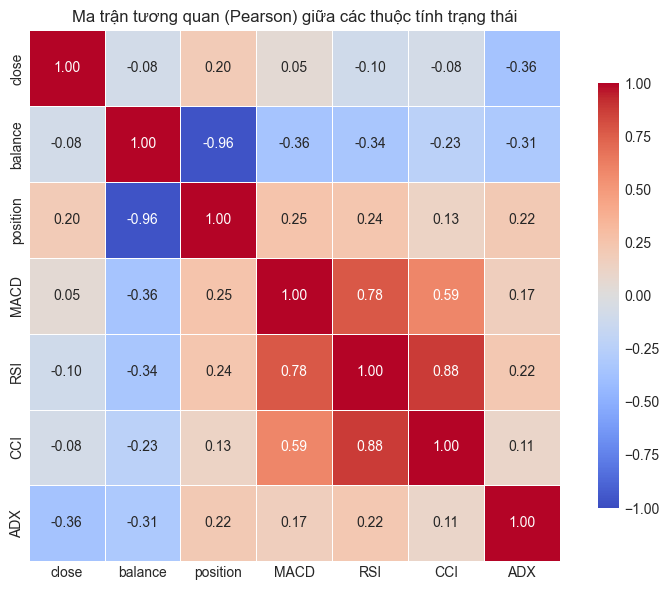

In [16]:
# Tính ma trận tương quan và vẽ heatmap
# Sử dụng dữ liệu states đã mô phỏng
X = np.array(states, dtype=np.float32)
feature_names = ['close','balance','position','MACD','RSI','CCI','ADX']

# Tạo DataFrame để tính tương quan
X_df = pd.DataFrame(X, columns=feature_names)

# Loại bỏ các hàng có NaN (nếu còn)
X_df_clean = X_df.dropna()

# Tính ma trận tương quan Pearson
corr = X_df_clean.corr(method='pearson')

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True,
            fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Ma trận tương quan (Pearson) giữa các thuộc tính trạng thái')
plt.tight_layout()
plt.show()

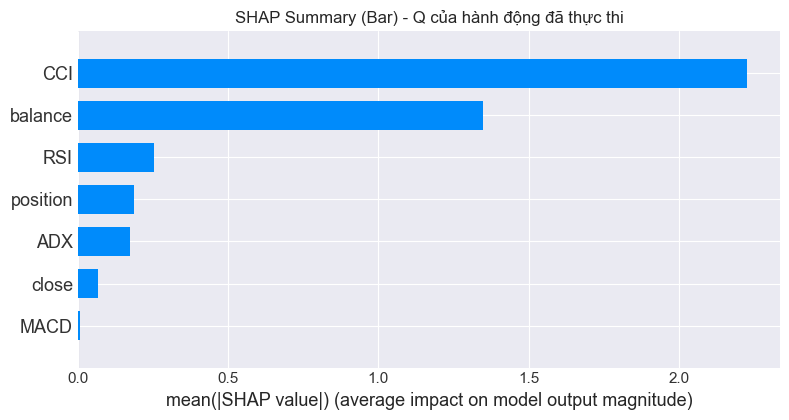

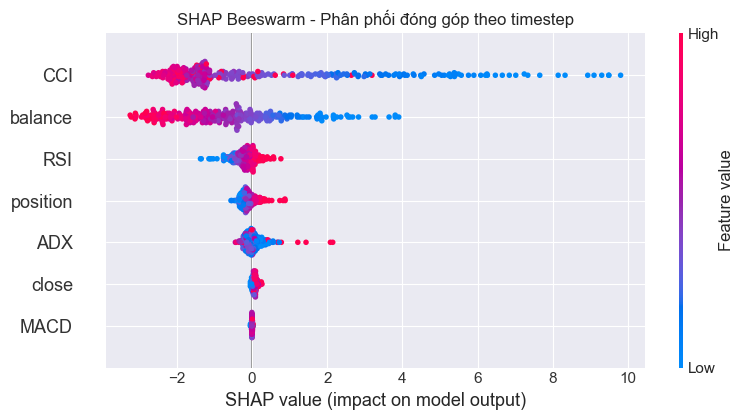

In [10]:
# Visualization: summary bar + beeswarm cho sample
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type='bar', show=False)
plt.title('SHAP Summary (Bar) - Q của hành động đã thực thi')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
plt.title('SHAP Beeswarm - Phân phối đóng góp theo timestep')
plt.tight_layout()
plt.show()

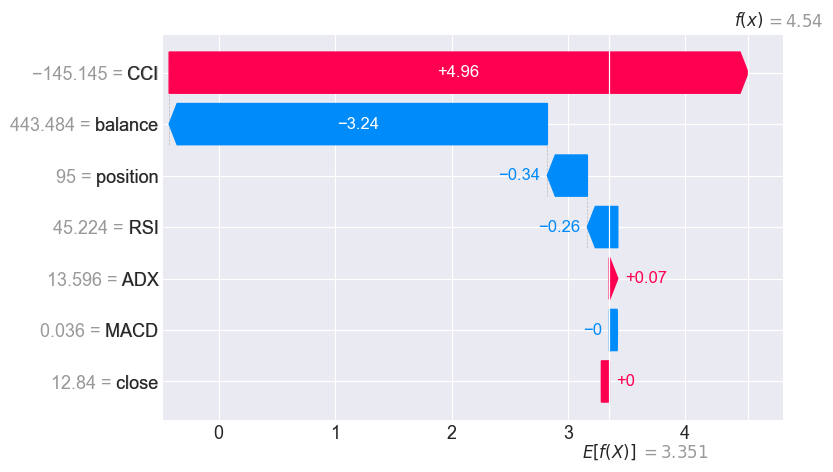

In [11]:
# Waterfall cho một timestep cụ thể (ví dụ timestep cuối cùng)
idx = -1  # phần tử cuối của sample
base_val = np.mean(predict_q_greedy(X_bg))
shap.plots.waterfall(shap.Explanation(values=shap_values[idx],
                                       base_values=base_val,
                                       data=X_sample[idx],
                                       feature_names=feature_names))

In [15]:
X

array([[   6.64    , 1000.      ,    0.      , ...,   51.322365,
          39.86254 ,   28.414156],
       [   6.64    ,  986.7067  ,    2.      , ...,   51.322365,
         105.84193 ,   26.62076 ],
       [   6.49    ,  953.4735  ,    7.      , ...,   40.880024,
         -69.80057 ,   26.12993 ],
       ...,
       [  12.9     ,  417.65823 ,   97.      , ...,   46.387547,
        -149.729   ,   13.039227],
       [  12.9     ,  430.57114 ,   96.      , ...,   46.387547,
        -149.02402 ,   13.327816],
       [  12.84    ,  443.48404 ,   95.      , ...,   45.22434 ,
        -145.14523 ,   13.595792]], dtype=float32)